In [1]:
import pandas as pd
import random
import math
import operator
import numpy as np
import scipy as sc
from IPython.display import display, HTML

In [2]:
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.formula.api as smf

from sklearn import linear_model
from sklearn import preprocessing
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix


/Users/ando/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns
from matplotlib import gridspec

%matplotlib inline
plt.style.use('smandry')

In [204]:
class ModelStat(object):
    """
    Calculate model statistics:
    
    Example:
    
    >>> linreg = linear_model.LinearRegression()
    >>> linreg_stat = ModelStat(linreg, advertising[['TV']], advertising.Sales)
    >>> display(linreg_stat.results)
    """
    def __init__(self, model, X, y, fit=False, linear=True, cols=None, hypothesis=0):
        if fit:
            model.fit(X,y)
        self.model = model
        self.y = y
        self.nobs = X.shape[0]
        self.npred = X.shape[1]
        self.pred = model.predict(X)
        if isinstance(X, pd.DataFrame):
            newX = np.hstack((np.ones(self.nobs).reshape(-1,1), X.values))
            cols = ['Intercept']+list(X.columns)
            rankX = np.linalg.matrix_rank(X.values)
        else:
            newX = np.hstack((np.ones(self.nobs).reshape(-1,1), X))
            rankX = np.linalg.matrix_rank(X)
        self.dof = ModelStat.dof(X)
        self.RSS = ModelStat.rss(self.y, self.pred)
        self.MSE = ModelStat.mean_squared_error(self.y, self.pred, dof=self.dof)
        self.TSS = ModelStat.tss(self.y)
        self.rsquare = ModelStat.rsquare(self.y, self.pred)
        self.rsquare_adj = ModelStat.rsquare_adj(X, self.y, self.pred)
        model_name = str(model.__class__).replace("<class '","").replace("'>","")
        if model_name == "sklearn.linear_model.base.LinearRegression":
            self.params = np.append(model.intercept_,model.coef_)
            self.cov_params = ModelStat.cov_matrix(newX)
            variance = self.MSE * (self.cov_params.diagonal())
            self.StdErr = np.sqrt(variance)
            self.tValues = self.params/self.StdErr
            self.pValues =[2*(1 - sc.stats.t.cdf(np.abs(i),(self.dof+1))) for i in self.tValues]
            tppf = sc.stats.t.isf(0.025, self.dof)
            self.confInt = [self.params-tppf*self.StdErr, self.params+tppf*self.StdErr]
            mydf = pd.DataFrame(index=cols)
            mydf["Coefs"],mydf["StdErr"],mydf["tValues"],mydf["pValue"] = [self.params,self.StdErr,self.tValues,self.pValues]
            mydf["[0.025"] = self.confInt[0]
            mydf["0.975]"] = self.confInt[1]
            self.results = mydf
        if model_name == "sklearn.linear_model.logistic.LogisticRegression":
            self.params = np.append(model.intercept_,model.coef_)
            predictions = model.predict_proba(X)
            likelihood = np.multiply(predictions[:,0], predictions[:,1])
            self.cov_params = ModelStat.covlogit_matrix(newX, likelihood)
            variance = np.diag(self.cov_params)
            self.StdErr = np.sqrt(variance)
            self.tValues = self.params/self.StdErr
            self.pValues =[2*(1 - sc.stats.t.cdf(np.abs(i),(self.dof+1))) for i in self.tValues]
            tppf = sc.stats.t.isf(0.025, self.dof)
            self.confInt = [self.params-tppf*self.StdErr, self.params+tppf*self.StdErr]
            mydf = pd.DataFrame(index=cols)
            mydf["Coefs"],mydf["StdErr"],mydf["Z-stat"],mydf["pValue"] = [self.params,self.StdErr,self.tValues,self.pValues]
            mydf["[0.025"] = self.confInt[0]
            mydf["0.975]"] = self.confInt[1]
            self.results = mydf
                        
    @staticmethod
    def rss(y, ypred):
        return sum((y - ypred)**2)

    @staticmethod
    def tss(y):
        return sum((y - y.mean())**2)

    @staticmethod
    def dof(X):
        return X.shape[0] - np.linalg.matrix_rank(X) -1
    
    @staticmethod
    def mean_squared_error(y, ypred, dof=None):
        rss = ModelStat.rss(y, ypred)
        if not dof: 
            dof = len(y)
        return rss/float(dof)
    
    @staticmethod    
    def rsquare(y, ypred):
        return 1.0 - (ModelStat.rss(y, ypred)/ModelStat.tss(y))
    
    @staticmethod    
    def rsquare_adj(X, y, ypred):
        return 1.0 - ((ModelStat.rss(y, ypred)/ModelStat.tss(y))*((X.shape[0]-1)/float(X.shape[0]-X.shape[1]-1)))

    @staticmethod
    def cov_matrix(newX):
        return np.linalg.pinv(np.dot(newX.T, newX))

    @staticmethod
    def covlogit_matrix(newX, likelihood):
        V = np.matrix(np.zeros(shape = (newX.shape[0], newX.shape[0])))
        np.fill_diagonal(V, likelihood)
        return np.linalg.pinv((newX.T).dot(V).dot(newX))
    
    def prediction_band(self, xnew, alpha=0.05, cols=None):
        """
        Prediction interval of new X (x0)
        
        pred +/- t * sqrt (MSE * (1 + x0' (X'X)-1 x0 )) 
        http://academic.macewan.ca/burok/Stat378/notes/moremultiple.pdf
        """
        pred = self.model.predict(xnew)
        xnew = np.hstack((np.ones(len(xnew)).reshape(-1,1), xnew))
        predvar = self.MSE * (1.0 + (xnew * np.dot(self.cov_params, xnew.T).T).sum(1))
        predstd = np.sqrt(predvar)
        tppf = sc.stats.t.isf(alpha/2., self.dof)
        interval_u = pred + tppf * predstd
        interval_l = pred - tppf * predstd
        if not cols: 
            cols = ['X'+str(i) for i in np.arange(xnew.shape[1]-1)]
        table = pd.DataFrame(np.zeros((len(xnew), xnew.shape[1]-1)), columns = cols)            
        for i, col in enumerate(cols):
            table[col] = xnew[:,i+1]
        table['fit'] = pred
        table['pred_lwr'] = interval_l
        table['pred_upr'] = interval_u
        return table
    
    def confidence_band(self, xnew, alpha=0.05, cols=None):
        """
        Confidence interval of new X (x0)
        
        pred +/- t * sqrt (MSE * x0' (X'X)-1 x0 )) 
        http://academic.macewan.ca/burok/Stat378/notes/moremultiple.pdf
        """
        pred = self.model.predict(xnew)
        xnew = np.hstack((np.ones(len(xnew)).reshape(-1,1), xnew))
        last_term = np.dot(self.cov_params, xnew.T)
        pred_mean_se = np.sqrt(self.MSE * (xnew * last_term.T).sum(1))
        tppf = sc.stats.t.isf(alpha/2.0, self.dof)
        mean_u = pred + tppf * pred_mean_se
        mean_l = pred - tppf * pred_mean_se
        if not cols: 
            cols = ['X'+str(i) for i in np.arange(xnew.shape[1]-1)]
        table = pd.DataFrame(np.zeros((len(xnew), xnew.shape[1]-1)), columns = cols)            
        for i, col in enumerate(cols):
            table[col] = xnew[:,i+1]
        table['fit'] = pred
        table['conf_lwr'] = mean_l
        table['conf_upr'] = mean_u
        return table
        

def anova_lm(*args):
    """
    Anova table for fitted linear models. Input: Model statistics
    
    Example:
    >>> lin1 = ModelStat(linreg, Credit[['Limit']], Credit['Balance'], fit=True)
    >>> lin2 = ModelStat(linreg, Credit[['Limit', 'Age']], Credit['Balance'], fit=True)
    >>> anova_lm(lin1,lin2)
    
    """
    names = ['dof', 'rss', 'dof_diff', 'rss_diff', 'F', 'Pr(>F)']
    n_models = len(args)
    scale = args[-1].RSS/float(args[-1].dof)
    table = pd.DataFrame(np.zeros((n_models, 6)), columns = names)
    table["rss"] = list(map(getattr, args, ["RSS"]*n_models))
    table["dof"] = list(map(getattr, args, ["dof"]*n_models))
    table.loc[table.index[1:], "dof_diff"] = -np.diff(table["dof"].values)
    table["rss_diff"] = - table["rss"].diff()
    table["F"] = table["rss_diff"] / table["dof_diff"] / scale
    table["Pr(>F)"] = sc.stats.f.sf(table["F"], table["dof_diff"], table["dof"])
    return table

# This is the same as statsmodel :
# lm_fit = smf.ols('Balance ~ Limit', data=Credit).fit()
# lm_fit2 = smf.ols('Balance ~ Limit + Age', data=Credit).fit()
# sm.stats.anova_lm(lm_fit, lm_fit2, typ=1)

# lin1 = ModelStat(linreg, Credit[['Limit']], Credit['Balance'], fit=True)
# lin2 = ModelStat(linreg, Credit[['Limit', 'Age']], Credit['Balance'], fit=True)
# anova_lm(lin1,lin2)        
        
        
# Function for creating grid    
def grid_create(model, XX, y, xstd, ystd, ngrid=20):
    xar = np.linspace(model.coef_[0]- xstd, model.coef_[0]+xstd, ngrid)
    yar = np.linspace(model.coef_[1]- ystd, model.coef_[1]+ystd, ngrid)
    xarr, yarr = np.meshgrid(xar, yar, indexing='xy')
    Z = np.zeros((xar.size,yar.size))
    xz = np.transpose(XX[:,0])
    yz = np.transpose(XX[:,1])
    intercept = model.intercept_
    for (i,j),v in np.ndenumerate(Z):
        coef1 = xarr[i,j]
        coef2 = yarr[i,j]
        Z[i,j] =sum((y - (intercept + coef1*xz + coef2*yz))**2)
    return(xarr,yarr,Z)

def print_diagtest(y, y_pred):
    # diagnostic test
    precision, recall, fscore, support = score(y, y_pred)
    # Finding accuracy score
    accuracy = accuracy_score(y_pred, y)
    print('precision: {}'.format(precision[1]))
    print('recall   : {}'.format(recall[1]))
    print('fscore   : {}'.format(fscore[1]))
    print('support  : {}'.format(support[1]))
    print "accuracy : {}".format(accuracy)
    # Confusion matrix
    display(pd.crosstab(y_pred, y,rownames=['Predicted'], colnames=['True'], margins=True))

# An Overview of Classification

In [5]:
# Read Default data
df = pd.read_excel('Data/Default.xlsx')
df['default2'] = df.default.factorize()[0]
df['student2'] = df.student.factorize()[0]
df.head(3)

,default,student,balance,income,default2,student2
1,No,No,729.526495,44361.625074,0,0
2,No,Yes,817.180407,12106.134700,0,1
3,No,No,1073.549164,31767.138947,0,0


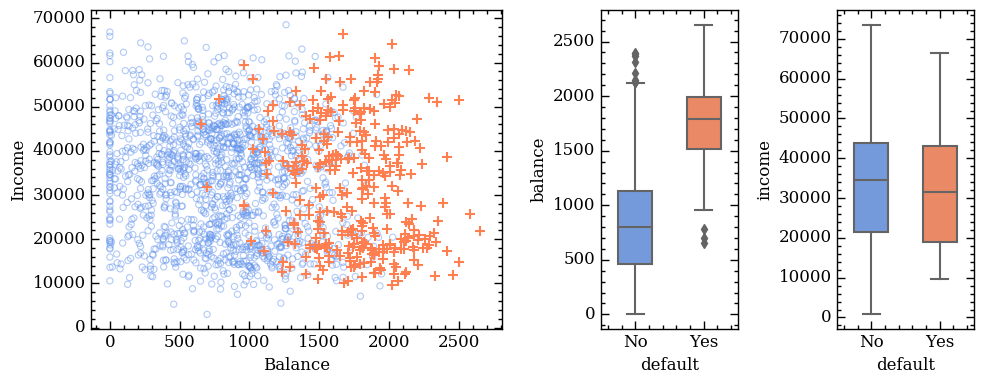

In [27]:
# Figure 4.1
fig = plt.figure(figsize=(10, 4)) 
gs = gridspec.GridSpec(1, 3, width_ratios=[3,1,1])
(ax1,ax2,ax3) = [plt.subplot(i) for i in gs]

subset_no = df[df.default == 'No'].sample(frac=0.15)
subset_yes = df[df.default == 'Yes']

ax1.scatter(subset_no.balance,subset_no.income,s=20, marker='o', facecolors='None', lw=0.8, edgecolors='cornflowerblue', alpha=0.5)
ax1.scatter(subset_yes.balance,subset_yes.income,s=60, c='coral', marker='+')
ax1.set_xlabel("Balance")
ax1.set_ylabel("Income")

c_palette = {'No':'cornflowerblue', 'Yes':'coral'}
sns.boxplot('default', 'balance', data=df, orient='v', width=0.5, ax=ax2, palette=c_palette)
sns.boxplot('default', 'income', data=df, orient='v', width=0.5, ax=ax3, palette=c_palette)
gs.tight_layout(plt.gcf())


# Logistic regression

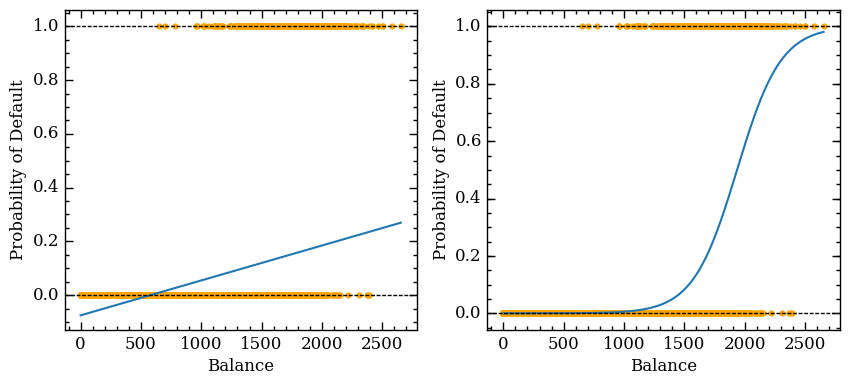

In [30]:
# Figure 4.2
X_test = np.arange(df.balance.min(), df.balance.max()).reshape(-1,1)
fig,(ax1,ax2) = plt.subplots(ncols=2, figsize=(10, 4))

# Linear Regression
reg = linear_model.LinearRegression()
reg.fit(df[['balance']],df.default2)
ax1.scatter(df.balance,df.default2, marker='o', lw=0, color='orange',facecolors=None)
ax1.plot(X_test, reg.predict(X_test))
for i in (0,1): ax1.axhline(i, color='k', ls='dashed', lw=1)

# Logistic Regression
logr = linear_model.LogisticRegression(solver='newton-cg')
logr.fit(df[['balance']],df.default2)
ax2.scatter(df.balance,df.default2, marker='o', lw=0, color='orange',facecolors=None)
ax2.plot(X_test, logr.predict_proba(X_test)[:,1])
for i in (0,1): ax2.axhline(i, color='k', ls='dashed', lw=1)
for axs in (ax1,ax2):
    axs.set_xlabel('Balance')
    axs.set_ylabel('Probability of Default')    

In [8]:
# Table 4.1
logr1 = linear_model.LogisticRegression(solver='newton-cg')
logr1_stat = ModelStat(logr1, df[['balance']],df.default2, fit=True)
display(logr1_stat.results)

,Coefs,StdErr,Z-stat,pValue,[0.025,0.975]
Intercept,-10.651321,0.361168,-29.491301,0.0,-11.359283,-9.943358
balance,0.005499,0.000220,24.952408,0.0,0.005067,0.005931


In [9]:
# proba with a Balance of $1000
print "Proba with Balance of $1000 = {0:7.5f}".format(logr1.predict_proba(np.matrix(1000.0))[0,1])

# proba with a Balance of $2000
print "Proba with Balance of $2000 = {0:7.5f}".format(logr1.predict_proba(np.matrix(2000.0))[0,1])


Proba with Balance of $1000 = 0.00575
Proba with Balance of $2000 = 0.58577


In [12]:
# Table 4.2 with qualitative predictor
logr1 = linear_model.LogisticRegression(solver='newton-cg')
logr1_stat = ModelStat(logr1, df[['student2']],df.default2, fit=True)
display(logr1_stat.results)

,Coefs,StdErr,Z-stat,pValue,[0.025,0.975]
Intercept,-3.502132,0.070647,-49.572430,0.000000,-3.640613,-3.363650
student2,0.399598,0.115086,3.472167,0.000518,0.174006,0.625189


In [14]:
# proba with a Balance of $1000
print "Proba default='yes' for student = {0:7.5f}".format(logr1.predict_proba(np.matrix(1))[0,1])

# proba with a Balance of $2000
print "Proba default='yes' for non-student = {0:7.5f}".format(logr1.predict_proba(np.matrix(0))[0,1])

Proba default='yes' for student = 0.04300
Proba default='yes' for non-student = 0.02925


# Multiple Logistic regression

In [25]:
# Table 4.3 with multiple predictor
df['income1000'] = df['income']/float(1000)
logr1 = linear_model.LogisticRegression(solver='newton-cg', max_iter=10000, tol=1e-5)
logr1_stat = ModelStat(logr1, df[['balance','income1000','student2']],df.default2, fit=True)
display(logr1_stat.results)

,Coefs,StdErr,Z-stat,pValue,[0.025,0.975]
Intercept,-10.901801,0.493158,-22.106093,0.000000,-11.868491,-9.935112
balance,0.005731,0.000232,24.735501,0.000000,0.005276,0.006185
income1000,0.003962,0.008208,0.482630,0.629369,-0.012129,0.020052
student2,-0.612570,0.236394,-2.591312,0.009575,-1.075950,-0.149191


## Confounding 

In [32]:
conf1 = df.loc[df['student']=='Yes',['balance','default2']]
conf2 = df.loc[df['student']=='No',['balance','default2']]
X_test = np.arange(df.balance.min(), df.balance.max()).reshape(-1,1)

lr1 = linear_model.LogisticRegression(solver='newton-cg')
lr1.fit(conf1[['balance']],conf1['default2'])
proba1 = lr1.predict_proba(X_test)

lr2 = linear_model.LogisticRegression(solver='newton-cg')
lr2.fit(conf2[['balance']],conf2['default2'])
proba2 = lr2.predict_proba(X_test)

Pstudent = conf1['default2'].sum()/float(len(conf1))
Pnonstudent = conf2['default2'].sum()/float(len(conf2))

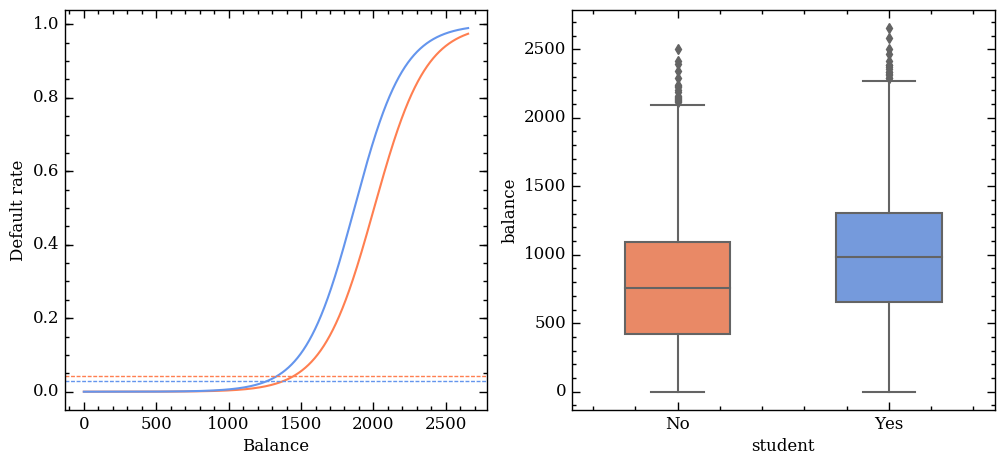

In [33]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,5))
ax1.plot(X_test, proba1[:,1], color='coral', label='Student')
ax1.plot(X_test, proba2[:,1], color='cornflowerblue', label='Non-student')
ax1.axhline(Pstudent, color='coral', ls='dashed', lw=1)
ax1.axhline(Pnonstudent, color='cornflowerblue', ls='dashed', lw=1)
ax1.set_xlabel("Balance")
ax1.set_ylabel("Default rate")
c_palette = {'Yes':'cornflowerblue', 'No':'coral'}
sns.boxplot('student', 'balance', data=df, width=0.5, orient='v', ax=ax2,  palette=c_palette)

In [37]:
# Proba of Default for a student with a credit card balance of $1500 and an income of $40000
print "Pr(default='yes'|student='yes',balance=$1500,income=$40000) = {0:7.5f}".format(logr1.predict_proba(np.matrix([1500.0,40.0,1]))[0,1])

# Proba of Default for a student with a credit card balance of $1500 and an income of $40000
print "Pr(default='yes'|student='no',balance=$1500,income=$40000) = {0:7.5f}".format(logr1.predict_proba(np.matrix([1500.0,40.0,0]))[0,1])


Pr(default='yes'|student='yes',balance=$1500,income=$40000) = 0.05952
Pr(default='yes'|student='no',balance=$1500,income=$40000) = 0.10457


## Linear Discriminant Analysis

- **Precision**: When a positive value is predicted, how often is the prediction correct? How "precise" is the classifier when predicting positive instances? The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.$$precision = \frac{TP}{(FP + TP)}$$


- **Recall** same as **True positive rate** or **sensitivity**: When the actual value is positive, how often is the prediction correct? How "sensitive" is the classifier to detecting positive instances? In our case the fraction of the defaulters that are correctly identified.  The recall is intuitively the ability of the classifier to find all the positive samples. $$recall = \frac{TP}{(FN + TP)}$$


- **False positive rate** (*Type 1 errors*): When the actual value is negative, how often is the prediction incorrect? In our case the fraction of the non-defaulters that we classified incorrectly as defaulter $$False~positive~rate = \frac{FP}{(TN + FP)}$$

- **Specificity**: When the actual value is negative, how often is the prediction correct? How "specific" (or "selective") is the classifier in predicting positive instances? $$specificity = \frac{TN}{(TN + FP)} = 1 - FPR$$


- **A Type 1 Error** is rejecting the null hypothesis when H0 is actually true. Here the Null hypothesis H0 is individual default, and Ha does not. Type 1 Error is then FPR and Type 2 error is (1 - TPR)

- **A Type 2 Error** is failing to reject the null hypothesis when the alternative is actually true.

In [206]:
lda = LinearDiscriminantAnalysis(solver='svd')
lda.fit(df[['balance','income1000','student2']],df.default2)
y_pred = lda.predict(df[['balance','income1000','student2']])

# diagnostic test
print_diagtest(df.default2, y_pred)

precision: 0.782178217822
recall   : 0.237237237237
fscore   : 0.364055299539
support  : 333
accuracy : 0.9724


True,0,1,All
Predicted,,,
0,9645,254,9899
1,22,79,101
All,9667,333,10000


### LDA for p=1

LDA assume that the observations with each class comes from a normal distribution with a class specific mean and standard deviation, and then plugging estimates of these parameters into the Bayes classifier.

In [132]:
x = np.linspace(-5,5,50)
data1 = sc.stats.norm.pdf(x, -1.25, 1)
data2 = sc.stats.norm.pdf(x, 1.25, 1) 

#20 random sample
np.random.seed(1)
y1 = np.random.normal(-1.25, 1.0, 20)
y2 = np.random.normal(1.25, 1.0, 20)

mu1 = sum(y1)/20.
mu2 = sum(y2)/20.
boundary = (mu1+mu2)/2.0

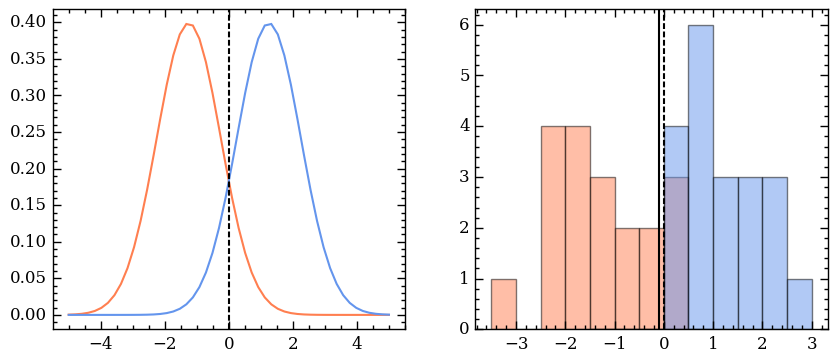

In [136]:
#Figure 4.4
fig,(ax1,ax2) = plt.subplots(ncols=2, figsize=(10, 4))
ax1.plot(x, data1, color='coral')
ax1.plot(x, data2, color = 'cornflowerblue')

ax2.hist(y1,bins= (np.arange(10)/2.0)-3.5 ,alpha=0.5, facecolor='coral',edgecolor='k')
ax2.hist(y2,bins= (np.arange(10)/2.0)-1.5 ,alpha=0.5, facecolor='cornflowerblue', edgecolor='k')
ax2.axvline(boundary, color='k')

for axs in (ax1,ax2):
    axs.axvline(0, ls='--', color='k')
plt.show()

### LDA for p>1

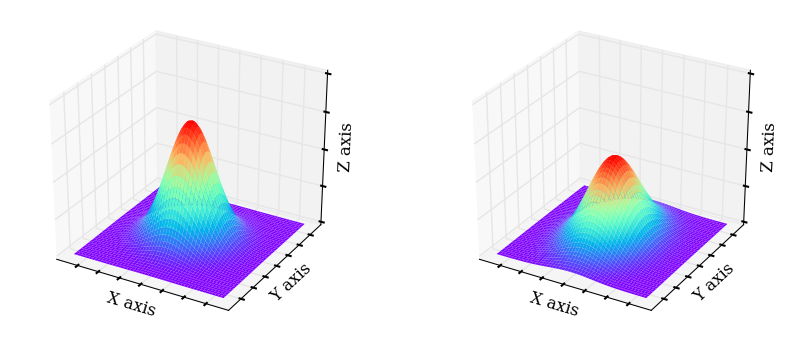

In [181]:
mean = [0,0]
cov1 = [[1,0],[0,1]]
cov2 = [[1.0,0],[0.0,2.0]]
#Create grid 
x = np.linspace(-3.5,3.5,500)
y = np.linspace(-3.5,3.5,500)
X, Y = np.meshgrid(x,y)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X; pos[:, :, 1] = Y
rv1 = sc.stats.multivariate_normal(mean, cov1)
rv2 = sc.stats.multivariate_normal(mean, cov2)

#Make a 3D plot
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(X, Y, rv1.pdf(pos),cmap='rainbow',linewidth=0)

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(X, Y, rv2.pdf(pos),cmap='rainbow',linewidth=0)

for ax in (ax1,ax2):
    ax.tick_params(labelbottom=False, labelleft=False)
    ax.set_zlim(0,0.2)
    ax.set_xlabel('X axis', labelpad=-10)
    ax.set_ylabel('Y axis', labelpad=-10)
    ax.set_zlabel('Z axis', labelpad=-10)
plt.show()

In [182]:
lda = LinearDiscriminantAnalysis(solver='svd')
lda.fit(df[['balance','income1000','student2']],df.default2)
y_pred = lda.predict(df[['balance','income1000','student2']])
# Confusion matrix
pd.crosstab(y_pred, df.default2, rownames=['Predicted'], colnames=['True'], margins=True)

True,0,1,All
Predicted,,,
0,9645,254,9899
1,22,79,101
All,9667,333,10000


In [207]:
# LDA use a threshold of 0.5. We can change the threshold to 0.2 (P(default='yes|X) >0.2) to increase the predicted defaulters
y_proba = lda.predict_proba(df[['balance','income1000','student2']])
y_pred = y_proba[:,1] > 0.2

print_diagtest(df.default2, y_pred)

precision: 0.454117647059
recall   : 0.57957957958
fscore   : 0.509234828496
support  : 333
accuracy : 0.9628


True,0,1,All
Predicted,,,
False,9435,140,9575
True,232,193,425
All,9667,333,10000


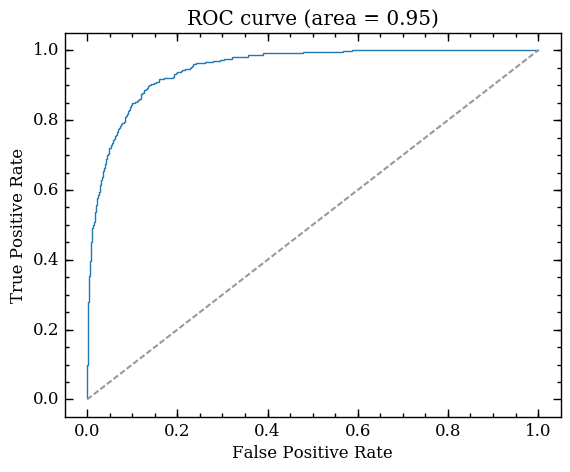

In [184]:
# ROC curve : sensitivity and 1 - specificity of our classifier
#from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(df.default2,y_proba[:,1]) 

# Calculate the area under the curve
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1)
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Chance')
plt.title('ROC curve (area = %0.2f)' % (roc_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# Lab : Logistic regression, LDA, QDA, KNN
## The stock market data

In [185]:
Smarket = pd.read_csv('Data/Smarket.csv', index_col=0, parse_dates=True)
Smarket.head(2)

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
1,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
2,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up


In [186]:
# Find Pairwise correlations among predictor
Smarket.corr()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,0.029700,0.030596,0.033195,0.035689,0.029788,0.539006,0.030095
Lag1,0.029700,1.000000,-0.026294,-0.010803,-0.002986,-0.005675,0.040910,-0.026155
Lag2,0.030596,-0.026294,1.000000,-0.025897,-0.010854,-0.003558,-0.043383,-0.010250
Lag3,0.033195,-0.010803,-0.025897,1.000000,-0.024051,-0.018808,-0.041824,-0.002448
Lag4,0.035689,-0.002986,-0.010854,-0.024051,1.000000,-0.027084,-0.048414,-0.006900
Lag5,0.029788,-0.005675,-0.003558,-0.018808,-0.027084,1.000000,-0.022002,-0.034860
Volume,0.539006,0.040910,-0.043383,-0.041824,-0.048414,-0.022002,1.000000,0.014592
Today,0.030095,-0.026155,-0.010250,-0.002448,-0.006900,-0.034860,0.014592,1.000000


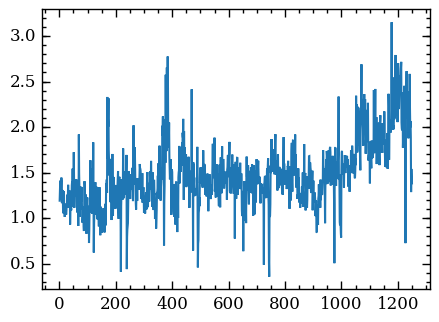

In [187]:
fig, ax = plt.subplots(figsize=(5,3.5))
ax.plot(Smarket.Volume)
plt.show()

In [190]:
# map Direction to integer for scikit
Smarket['Direction1'] = Smarket['Direction'].map({'Up':1, 'Down':0})
# Logistic regression
smLR = linear_model.LogisticRegression(solver='newton-cg', max_iter=1000)
smLR_stat = ModelStat(smLR, Smarket[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']], Smarket.Direction1, fit=True)
smLR_stat.results

,Coefs,StdErr,Z-stat,pValue,[0.025,0.975]
Intercept,-0.121079,0.240720,-0.502986,0.615063,-0.593342,0.351184
Lag1,-0.072844,0.050166,-1.452066,0.146735,-0.171263,0.025575
Lag2,-0.042235,0.050085,-0.843273,0.399238,-0.140496,0.056025
Lag3,0.011016,0.049938,0.220597,0.825442,-0.086955,0.108987
Lag4,0.009284,0.049973,0.185773,0.852653,-0.088757,0.107325
Lag5,0.010263,0.049511,0.207298,0.835811,-0.086870,0.107397
Volume,0.132108,0.158347,0.834299,0.404273,-0.178548,0.442764


In [208]:
sm_proba = smLR.predict_proba(Smarket[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']])
# Print the first 10 probability
print "First 10 proba: ["+", ".join([str(i) for i in sm_proba[:10,1]])+"]"
print

sm_pred = sm_proba[:,1] > 0.5

# diagnostic test
print_diagtest(Smarket.Direction1, sm_pred)

First 10 proba: [0.49822926575, 0.489155400211, 0.485079326971, 0.509802567958, 0.514347795926, 0.498241024829, 0.483703985235, 0.498573541508, 0.520112065067, 0.495156137008]

precision: 0.529333333333
recall   : 0.612654320988
fscore   : 0.567954220315
support  : 648
accuracy : 0.5168


True,0,1,All
Predicted,,,
False,249,251,500
True,353,397,750
All,602,648,1250


In [210]:
# Test error
train = Smarket[Smarket.Year<2005]
test = Smarket[Smarket.Year>=2005]

# Using only Year < 2005 as a train dataset 
smLR1 = linear_model.LogisticRegression(solver='newton-cg', max_iter=1000)
smLR_stat = ModelStat(smLR1, train[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']], train.Direction1, fit=True)
smLR_stat.results

,Coefs,StdErr,Z-stat,pValue,[0.025,0.975]
Intercept,0.182594,0.333671,0.547229,0.584344,-0.472188,0.837376
Lag1,-0.054102,0.051784,-1.044761,0.296388,-0.155720,0.047517
Lag2,-0.045594,0.051795,-0.880272,0.378925,-0.147234,0.056047
Lag3,0.007278,0.051643,0.140925,0.887958,-0.094064,0.108620
Lag4,0.006539,0.051704,0.126479,0.899379,-0.094923,0.108002
Lag5,-0.004159,0.051137,-0.081322,0.935202,-0.104508,0.096191
Volume,-0.109954,0.239605,-0.458896,0.646409,-0.580145,0.360237


In [212]:
sm_pred = smLR1.predict(test[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']])

# diagnostic test
print_diagtest(test.Direction1, sm_pred)

precision: 0.564705882353
recall   : 0.340425531915
fscore   : 0.424778761062
support  : 141
accuracy : 0.484126984127


True,0,1,All
Predicted,,,
0,74,93,167
1,37,48,85
All,111,141,252


In [213]:
# Only use 2 predictors with highest p-values which are lag1 and lag2
smLR1 = linear_model.LogisticRegression(solver='newton-cg', max_iter=1000)
smLR_stat = ModelStat(smLR1, train[['Lag1', 'Lag2']], train.Direction1, fit=True)
smLR_stat.results

# predict
sm_pred = smLR1.predict(test[['Lag1', 'Lag2']])

# diagnostic test
print_diagtest(test.Direction1, sm_pred)

precision: 0.582417582418
recall   : 0.751773049645
fscore   : 0.656346749226
support  : 141
accuracy : 0.559523809524


True,0,1,All
Predicted,,,
0,35,35,70
1,76,106,182
All,111,141,252


In [214]:
# predict with lag1 = [1.2,1.5] and lag2=[1.1,0.8]
smLR1.predict_proba(np.matrix([[1.2,1.1], [1.5,-0.8]]))[:,1]

array([ 0.47922482,  0.49612601])

In [215]:
# or using dataframe
smLR1.predict_proba(pd.DataFrame({'lag1':[1.2,1.5], 'lag2':[1.1,-0.8]}))[:,1]

array([ 0.47922482,  0.49612601])

# Lab: LDA

In [216]:
smlda = LinearDiscriminantAnalysis()
smlda.fit(train[['Lag1', 'Lag2']], train.Direction1)
y_pred = smlda.predict(test[['Lag1', 'Lag2']])

# printing diagnostic test
print_diagtest(test.Direction1, y_pred)

precision: 0.582417582418
recall   : 0.751773049645
fscore   : 0.656346749226
support  : 141
accuracy : 0.559523809524


True,0,1,All
Predicted,,,
0,35,35,70
1,76,106,182
All,111,141,252


## Quadratic Discriminant Analysis

In [217]:
smqda = QuadraticDiscriminantAnalysis()
smqda.fit(train[['Lag1', 'Lag2']], train.Direction1)
y_pred = smqda.predict(test[['Lag1', 'Lag2']])

# printing diagnostic test
print_diagtest(test.Direction1, y_pred)

precision: 0.59900990099
recall   : 0.858156028369
fscore   : 0.705539358601
support  : 141
accuracy : 0.599206349206


True,0,1,All
Predicted,,,
0,30,20,50
1,81,121,202
All,111,141,252


**QDA** captured the true relationship more accurately than the linear forms assumed by **LDA** and **Logistic regression**

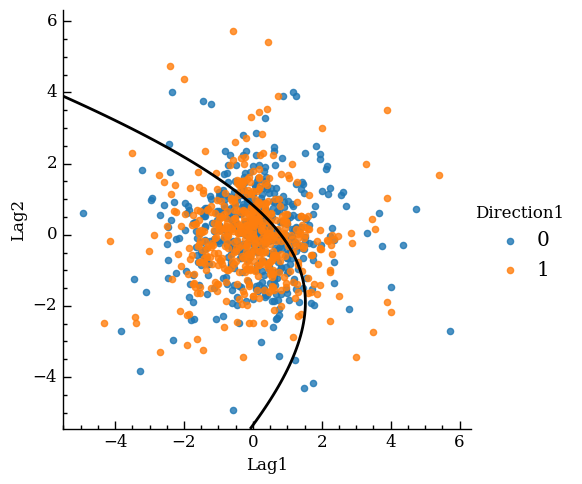

In [218]:
from matplotlib import colors
# Colormap
cmap = colors.LinearSegmentedColormap(
    'red_blue_classes',
    {'red': [(0, 1, 1), (1, 0.7, 0.7)],
     'green': [(0, 0.7, 0.7), (1, 0.7, 0.7)],
     'blue': [(0, 0.7, 0.7), (1, 1, 1)]})
plt.cm.register_cmap(cmap=cmap)

sns.lmplot(x='Lag1', y='Lag2', hue='Direction1', data=train, fit_reg=False)
# class 0 and 1 : areas
nx, ny = 200, 100
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                     np.linspace(y_min, y_max, ny))
Z = smqda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z[:, 1].reshape(xx.shape)
#plt.pcolormesh(xx, yy, Z, alpha=0.1,cmap='red_blue_classes', norm=colors.Normalize(0.0,1.0))
plt.contour(xx, yy, Z, [0.5], linewidths=2., colors='k')
plt.show()

## K-Nearest Neighbors

In [219]:
smknn = KNeighborsClassifier(n_neighbors=1)
smknn.fit(train[['Lag1', 'Lag2']], train.Direction1)
y_pred = smknn.predict(test[['Lag1', 'Lag2']])

# printing diagnostic test
print_diagtest(test.Direction1, y_pred)

precision: 0.549668874172
recall   : 0.58865248227
fscore   : 0.568493150685
support  : 141
accuracy : 0.5


True,0,1,All
Predicted,,,
0,43,58,101
1,68,83,151
All,111,141,252


In [220]:
# Change the number of Neighbors to K = 3
smknn = KNeighborsClassifier(n_neighbors=3)
smknn.fit(train[['Lag1', 'Lag2']], train.Direction1)
y_pred = smknn.predict(test[['Lag1', 'Lag2']])

# printing diagnostic test
print_diagtest(test.Direction1, y_pred)

precision: 0.577181208054
recall   : 0.609929078014
fscore   : 0.593103448276
support  : 141
accuracy : 0.531746031746


True,0,1,All
Predicted,,,
0,48,55,103
1,63,86,149
All,111,141,252


In [221]:
# Change the number of Neighbors to K = 6
smknn = KNeighborsClassifier(n_neighbors=5)
smknn.fit(train[['Lag1', 'Lag2']], train.Direction1)
y_pred = smknn.predict(test[['Lag1', 'Lag2']])

# printing diagnostic test
print_diagtest(test.Direction1, y_pred)

precision: 0.535947712418
recall   : 0.581560283688
fscore   : 0.557823129252
support  : 141
accuracy : 0.484126984127


True,0,1,All
Predicted,,,
0,40,59,99
1,71,82,153
All,111,141,252


Increasing K > 3 did not improve the fit. This means that the best method we got so far is the **QDA** with an accuracy of 0.599 (60%)

# Lab: Caravan Insurance Data

In [222]:
Caravan = pd.read_csv('Data/Caravan.csv')
Caravan.head(2)

,Unnamed: 0,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,Purchase
0,1,33,1,3,2,8,0,5,1,3,...,0,0,0,1,0,0,0,0,0,No
1,2,37,1,2,2,8,1,4,1,4,...,0,0,0,1,0,0,0,0,0,No


In [223]:
Caravan.Purchase.describe()

count     5822
unique       2
top         No
freq      5474
Name: Purchase, dtype: object

In [224]:
# Standardize the data to have a zero mean and standard deviation of 1
scaler = preprocessing.StandardScaler()
Caravan_std = scaler.fit_transform(Caravan.loc[:, Caravan.columns != 'Purchase'])
test_car = Caravan_std[:1000,:]
y_test = Caravan.Purchase.values[:1000]
train_car = Caravan_std[1000:,:]
y_train = Caravan.Purchase.values[1000:]

In [225]:
carknn = KNeighborsClassifier(n_neighbors=1)
carknn.fit(train_car, y_train)
y_pred = carknn.predict(test_car)

# printing diagnostic test
print_diagtest(y_test, y_pred)

precision: 0.157142857143
recall   : 0.186440677966
fscore   : 0.170542635659
support  : 59
accuracy : 0.893


True,No,Yes,All
Predicted,,,
No,882,48,930
Yes,59,11,70
All,941,59,1000


In [226]:
# Using K=3
carknn = KNeighborsClassifier(n_neighbors=3)
carknn.fit(train_car, y_train)
y_pred = carknn.predict(test_car)

# printing diagnostic test
print_diagtest(y_test, y_pred)

precision: 0.230769230769
recall   : 0.101694915254
fscore   : 0.141176470588
support  : 59
accuracy : 0.927


True,No,Yes,All
Predicted,,,
No,921,53,974
Yes,20,6,26
All,941,59,1000


In [227]:
# Using K=5
carknn = KNeighborsClassifier(n_neighbors=5)
carknn.fit(train_car, y_train)
y_pred = carknn.predict(test_car)

# printing diagnostic test
print_diagtest(y_test, y_pred)

precision: 0.363636363636
recall   : 0.0677966101695
fscore   : 0.114285714286
support  : 59
accuracy : 0.938


True,No,Yes,All
Predicted,,,
No,934,55,989
Yes,7,4,11
All,941,59,1000


# Testing the logistic regression on the Car insurance data

In [228]:
carLR = linear_model.LogisticRegression(solver='newton-cg', max_iter=1000)
carLR.fit(train_car, y_train)
y_pred = carLR.predict(test_car)

# printing diagnostic test
print_diagtest(y_test, y_pred)

precision: 0.0
recall   : 0.0
fscore   : 0.0
support  : 59
accuracy : 0.935


True,No,Yes,All
Predicted,,,
No,935,59,994
Yes,6,0,6
All,941,59,1000


Only 6 were predicted to buy car insurance and all of them are wrong